# scikit-learnのトレーニング♨

## 多項式回帰、正則化回帰分析 編

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インポート](#インポート)
  - [プロキシ設定](#プロキシ設定)
  - [共通関数定義](#共通関数定義)
- [モデル・アルゴリズム](#モデル・アルゴリズム)
  - [多項式回帰分析](#多項式回帰分析)
  - [正則化回帰分析](#正則化回帰分析)

## 参考
開発基盤部会 Wiki
- データマイニング（DM）- Python  
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20Python#y4054d35

## [環境準備](ScikitLearnTraining0.ipynb)

### インポート

In [1]:
import io
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets                                 # サンプル・データセット
from sklearn.datasets import make_regression                 # 回帰データセット作成
from sklearn.datasets import make_blobs                      # 分類データセット作成
from sklearn.preprocessing import StandardScaler             # 標準化
from sklearn.model_selection import train_test_split         # データ分割

from sklearn.linear_model import LinearRegression            # 線形回帰
from sklearn.preprocessing import PolynomialFeatures         # 多項式回帰の変数変換
from sklearn.linear_model import Ridge                       # 多項式回帰のRidge回帰
from sklearn.linear_model import Lasso                       # 多項式回帰のLASSO回帰
from sklearn.linear_model import ElasticNet                  # 多項式回帰のLASSO回帰
from sklearn.linear_model import Perceptron                  # 単純パーセプトロン線形分類器
from sklearn.linear_model import LogisticRegression          # ロジスティク回帰
from sklearn.svm import SVC                                  # サポートベクターマシン（SVM）分類器
from sklearn.tree import DecisionTreeClassifier              # 決定木（分類木）
from sklearn.ensemble import RandomForestClassifier          # ランダムフォレスト（分類木）
from sklearn.ensemble import GradientBoostingClassifier      # 勾配ブースティング木（分類木）
from sklearn.decomposition import PCA                        # 主成分分析
from sklearn.cluster import KMeans                           # k-means法 クラスタ分析
from sklearn.feature_extraction.text import CountVectorizer  # 自然言語処理ベクトル化
from sklearn.feature_extraction.text import TfidfTransformer # 自然言語ベクトルのTF-IDF計算
from sklearn.decomposition import LatentDirichletAllocation  # 自然言語ベクトルからLDAトピック抽出

from sklearn import metrics                                  # モデル評価
from sklearn.metrics import mean_squared_error as mse        # 精度評価（mse）
from sklearn.metrics import confusion_matrix                 # 混同行列
from sklearn.metrics import silhouette_samples               # シルエット係数
from sklearn.model_selection import cross_val_score          # 交差検証法
from sklearn.model_selection import KFold                    # k分割交差検証法
from sklearn.model_selection import StratifiedKFold          # 層化交差検証法
from sklearn.model_selection import GridSearchCV             # グリッドサーチ

import seaborn as sns                                        # matplotlibラッパ
from mlxtend.plotting import plot_decision_regions           # 決定領域表示関数
from matplotlib import cm                                    # カラーマップ処理

from numpy import linalg as LA                               # 線形代数ライブラリ

In [2]:
import warnings
warnings.filterwarnings('ignore')

### プロキシ設定

In [3]:
import os
proxies = {
    "http": os.getenv("HTTP_PROXY"),
    "https": os.getenv("HTTPS_PROXY")
}

### 共通関数定義

#### 自由度調整済み決定係数（R2乗値）の関数

In [4]:
def adjusted(score, n_sample, n_explanatory_variables):
    adjusted_score = 1 - (1 - score) * ((n_sample - 1) / (n_sample - n_explanatory_variables - 1))
    return adjusted_score

#### 残差プロットを行う関数

In [5]:
def res_plot(y_train, y_train_pred, y_test, y_test_pred):
    # train, testごとに残差を算出
    res_train = y_train_pred - y_train
    res_test  = y_test_pred - y_test
    
    # train, testごとに(予測値, 残差)をプロット
    plt.figure(figsize=(8, 8))
    plt.scatter(y_train_pred, res_train, color='blue', marker='o', label='train', alpha=0.5)
    plt.scatter(y_test_pred, res_test, color='green', marker='s', label='test', alpha=0.5)
    
    plt.xlabel('Predicted Values')                  # x軸のラベルを表示
    plt.ylabel('Residuals')                         # y軸のラベルを表示
    plt.legend(loc='upper left')                    # 凡例を左上に表示
    plt.hlines(y=0, xmin=-10, xmax=50, color='red') # 残差0の線を表示
    plt.xlim([-10, 50])                             # 表示する横軸の範囲を指定
    plt.show()

## モデル・アルゴリズム

### 多項式回帰分析
交互作用など、重回帰の問題の解消のため非線形性を導入。

※ [イメージ](https://www.google.com/search?q=多項式回帰&tbm=isch)、[説明](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%B5%B1%E8%A8%88%E8%A7%A3%E6%9E%90#oe32e0f1)

#### データ

##### 生成・加工・理解
- 重回帰の問題の解消のためなので、[重回帰](ScikitLearnTraining1.ipynb)と同じデータの生成・加工・理解を行う。
- 必要に応じて[環境変数にプロキシ設定](#プロキシ設定)をしておくと良い。

In [6]:
url = 'https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?plugin=attach&pcmd=open&file=Boston.csv&refer=FrontPage'
res = requests.get(url) # , verify=False, proxies=proxies) # プロキシ
df = pd.read_csv(io.BytesIO(res.content), encoding='utf-8', sep=",")
df = df.drop('Unnamed: 0',axis=1)
df = df.loc[:, ['lstat', 'indus', 'dis', 'rm', 'medv']]
df

,lstat,indus,dis,rm,medv
0,4.98,2.31,4.0900,6.575,24.0
1,9.14,7.07,4.9671,6.421,21.6
2,4.03,7.07,4.9671,7.185,34.7
3,2.94,2.18,6.0622,6.998,33.4
4,5.33,2.18,6.0622,7.147,36.2
...,...,...,...,...,...
501,9.67,11.93,2.4786,6.593,22.4
502,9.08,11.93,2.2875,6.120,20.6
503,5.64,11.93,2.1675,6.976,23.9
504,6.48,11.93,2.3889,6.794,22.0


##### 準備
ここから[重回帰](ScikitLearnTraining1.ipynb)と異なる。

###### 共通
交互作用が解消できるということなので、説明変数を多めにしておく。

In [7]:
# 説明変数・目的変数の選択・分割
x_org = np.array(df.drop(['medv'], axis=1))
# x = np.array(df.drop(['indus', 'dis', 'medv'], axis=1))
y_org = np.array(df.loc[:, ['medv']])
# データをスライシングして確認。
print(x_org[:5])
print(y_org[:5])

[[4.98   2.31   4.09   6.575 ]
 [9.14   7.07   4.9671 6.421 ]
 [4.03   7.07   4.9671 7.185 ]
 [2.94   2.18   6.0622 6.998 ]
 [5.33   2.18   6.0622 7.147 ]]
[[24. ]
 [21.6]
 [34.7]
 [33.4]
 [36.2]]


In [8]:
# 学習・テストデータの分割（ホールド・アウト法
x_train_lin, x_test_lin, y_train, y_test = train_test_split(x_org, y_org, test_size = 0.3, random_state = 0)

###### 個別
多項式基底関数で変数変換を実行（非線形性の導入

In [9]:
# 2次関数
quad = PolynomialFeatures(degree=2)
x_quad = quad.fit_transform(x_org)

# 学習・テストデータの分割（ホールド・アウト法
x_train_quad, x_test_quad, y_train, y_test = train_test_split(x_quad, y_org, test_size = 0.3, random_state = 0)

In [10]:
# 3次関数
cubic = PolynomialFeatures(degree=3)
x_cubic = cubic.fit_transform(x_org)

# 学習・テストデータの分割（ホールド・アウト法
x_train_cubic, x_test_cubic, y_train, y_test = train_test_split(x_cubic, y_org, test_size = 0.3, random_state = 0)

#### モデリング

##### 学習

##### １次関数

In [11]:
# x_train_linで、model_linを学習
model_lin = LinearRegression()
model_lin.fit(x_train_lin, y_train)

LinearRegression()

##### ２次関数

In [12]:
# x_train_quadで、model_quadを学習
model_quad = LinearRegression()
model_quad.fit(x_train_quad, y_train)

LinearRegression()

##### ３次関数

In [13]:
# x_train_cubicで、model_cubicを学習
model_cubic = LinearRegression()
model_cubic.fit(x_train_cubic, y_train)

LinearRegression()

##### 推論
※ predictは多変量に対応しているので二次元配列であること。

##### １次関数

In [14]:
index=6
new_val = np.array([x_test_lin[index]])
pred_val = model_lin.predict(new_val)
ratio_val = y_test[index] / pred_val[0]
print('answer = ', y_test[index])
print('pred = ', pred_val[0])
print('ratio : %.2f' % ratio_val)

answer =  [20.6]
pred =  [20.19291415]
ratio : 1.02


##### ２次関数

In [15]:
index=6
new_val = np.array([x_test_quad[index]])
pred_val = model_quad.predict(new_val)
ratio_val = y_test[index] / pred_val[0]
print('answer = ', y_test[index])
print('pred = ', pred_val[0])
print('ratio : %.2f' % ratio_val)

answer =  [20.6]
pred =  [21.16299173]
ratio : 0.97


##### ３次関数

In [16]:
index=6
new_val = np.array([x_test_cubic[index]])
pred_val = model_cubic.predict(new_val)
ratio_val = y_test[index] / pred_val[0]
print('answer = ', y_test[index])
print('pred = ', pred_val[0])
print('ratio : %.2f' % ratio_val)

answer =  [20.6]
pred =  [20.24704559]
ratio : 1.02


#### 評価

##### 自由度調整済み決定係数（R2乗値）

###### １次関数

In [17]:
print('train: %.3f' % adjusted(model_lin.score(x_train_lin, y_train), len(y_train), x_train_lin.shape[1]))
print('test : %.3f' % adjusted(model_lin.score(x_test_lin, y_test), len(y_test), x_test_lin.shape[1]))

train: 0.674
test : 0.605


###### ２次関数

In [18]:
print('train: %.3f' % adjusted(model_quad.score(x_train_quad, y_train), len(y_train), x_train_quad.shape[1]))
print('test : %.3f' % adjusted(model_quad.score(x_test_quad, y_test), len(y_test), x_test_quad.shape[1]))

train: 0.840
test : 0.710


###### ３次関数

In [19]:
print('train: %.3f' % adjusted(model_cubic.score(x_train_cubic, y_train), len(y_train), x_train_cubic.shape[1]))
print('test : %.3f' % adjusted(model_cubic.score(x_test_cubic, y_test), len(y_test), x_test_cubic.shape[1]))

train: 0.887
test : 0.643


##### [スコアを表示](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)
- 平均二乗誤差（MSE：Mean Squared Error）
- 誤差の標準偏差（RMSE : Root Mean Squared Error）

###### １次関数

In [20]:
lin_train_mse = mse(y_train, model_lin.predict(x_train_lin))
lin_test_mse = mse(y_test, model_lin.predict(x_test_lin))

print('lin_train_mse: %.3f' % lin_train_mse)
print('lin_test_mse: %.3f' % lin_test_mse)
print('lin_train_rmse: %.3f' % (lin_train_mse ** (1/2)))
print('lin_test_rmse : %.3f' % (lin_test_mse ** (1/2)))

lin_train_mse: 27.317
lin_test_mse: 31.998
lin_train_rmse: 5.227
lin_test_rmse : 5.657


###### ２次関数

In [21]:
quad_train_mse = mse(y_train, model_quad.predict(x_train_quad))
quad_test_mse = mse(y_test, model_quad.predict(x_test_quad))

print('quad_train_mse: %.3f' % quad_train_mse)
print('quad_test_mse: %.3f' % quad_test_mse)
print('quad_train_rmse: %.3f' % (quad_train_mse ** (1/2)))
print('quad_test_rmse : %.3f' % (quad_test_mse ** (1/2)))

quad_train_mse: 13.012
quad_test_mse: 21.778
quad_train_rmse: 3.607
quad_test_rmse : 4.667


###### ３次関数

In [22]:
cubic_train_mse = mse(y_train, model_cubic.predict(x_train_cubic))
cubic_test_mse = mse(y_test, model_cubic.predict(x_test_cubic))

print('cubic_train_mse: %.3f' % cubic_train_mse)
print('cubic_test_mse: %.3f' % cubic_test_mse)
print('cubic_train_rmse: %.3f' % (cubic_train_mse ** (1/2)))
print('cubic_test_rmse : %.3f' % (cubic_test_mse ** (1/2)))

cubic_train_mse: 8.619
cubic_test_mse: 22.809
cubic_train_rmse: 2.936
cubic_test_rmse : 4.776


##### 残差プロットを行う。
- 説明変数が３変数以上でも適用できる。
- 参考：https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#i3d85f2b

###### １次関数

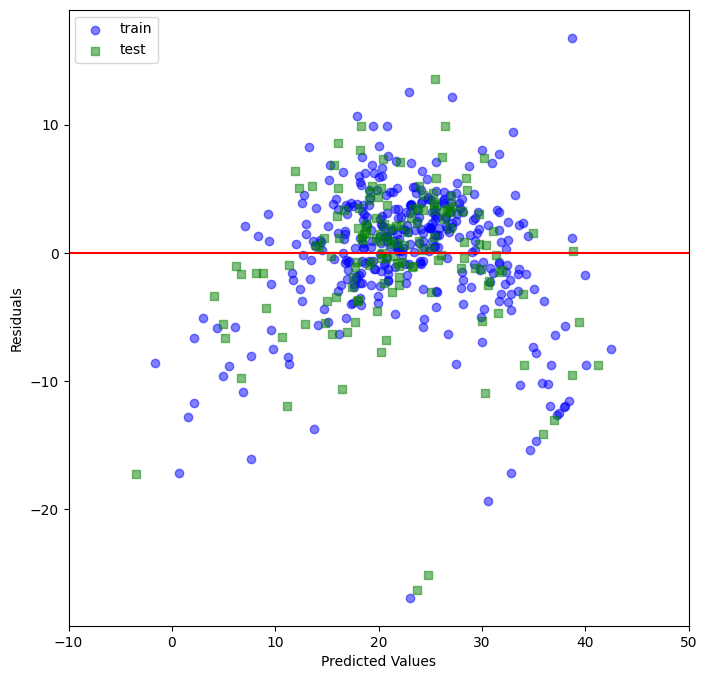

In [23]:
# 残差プロットを出力
res_plot(y_train, model_lin.predict(x_train_lin), y_test, model_lin.predict(x_test_lin))

###### ２次関数

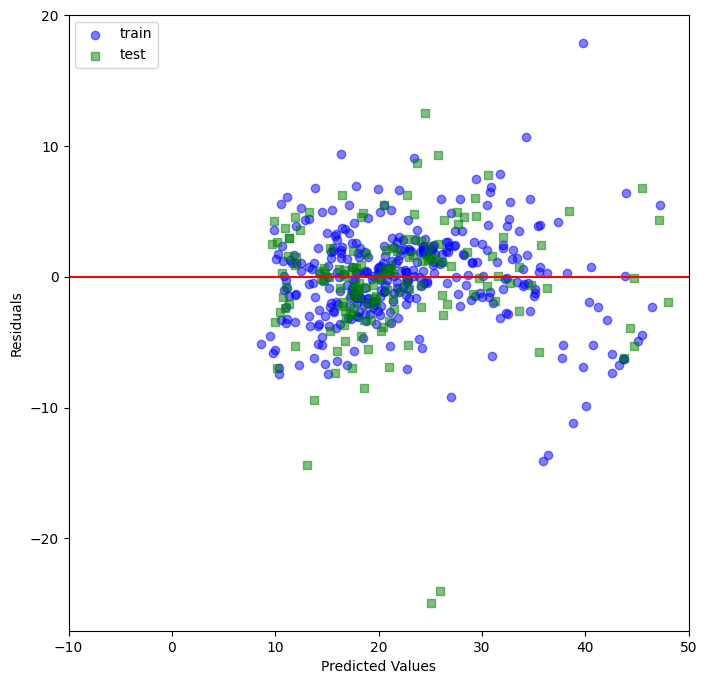

In [24]:
# 残差プロットを出力
res_plot(y_train, model_quad.predict(x_train_quad), y_test, model_quad.predict(x_test_quad))

###### ３次関数

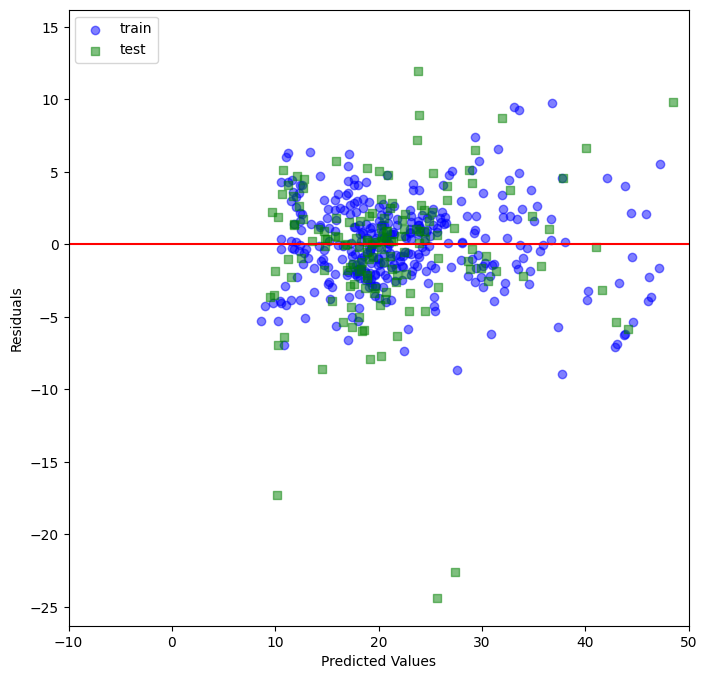

In [25]:
# 残差プロットを出力
res_plot(y_train, model_cubic.predict(x_train_cubic), y_test, model_cubic.predict(x_test_cubic))

### 正則化回帰分析
- 正則化で非線形性を導入した多項式回帰分析の過学習を防ぐ。
- 正則化では重みを制限しモデルの複雑さを抑えることで過学習を防ぐ。正則化回帰
- 正則化最小二乗法で正則化項を加えた（最小二乗法 > 勾配降下法 > ）誤差関数を使用する。

※ [イメージ](https://www.google.com/search?q=正則化回帰&tbm=isch)、[説明](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%B5%B1%E8%A8%88%E8%A7%A3%E6%9E%90#i38c7fea)

#### データ

##### 生成

###### 適当な関数を定義

In [26]:
def GenerateData1(x):
    y = 0.0001 * (x**3 + x**2 + x + 1)
    return y

###### 関数上のプロット

In [27]:
# xの範囲を指定
x_plot = np.arange(-25, 25, 0.1)
# yを関数で指定
y_plot = GenerateData1(x_plot)
# 機械学習用に変換
x_plot = x_plot.reshape(-1, 1)

###### サンプルの生成

In [28]:
# 乱数生成器の状態を指定
np.random.seed(3)
# 正規分布に従ってX個のデータ点を生成
X = 30
x_train = np.random.normal(0, 10, X)
# 対応するyを関数で生成
y_train = GenerateData1(x_train)
# 正規分布に従うノイズを加える
y_train += np.random.normal(0, 0.25, len(y_train))
# 機械学習用に変換
x_train = x_train.reshape(-1, 1)

###### 関数の描画と散布図で可視化
コレで、
- 多項式回帰の次数を上げて過学習させ、
- それを正則化回帰で抑止してみる。

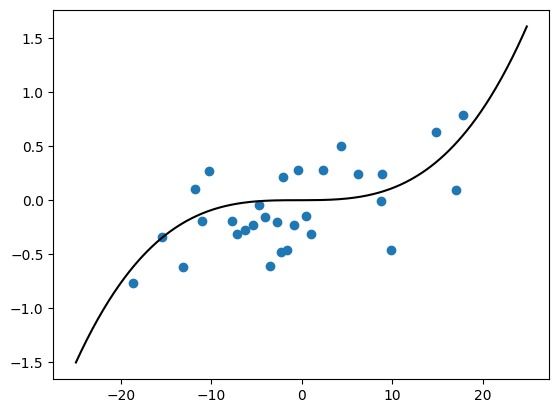

In [29]:
# 関数を描画
plt.plot(x_plot, y_plot, color='black')
# サンプルを散布
plt.scatter(x_train, y_train)
# グラフを表示
plt.show()

##### 加工
なし

##### 準備
なし（ここでは訓練データのみ使用するので、データ分割しない。

###### プロット・データはテスト・データ

In [30]:
x_test = x_plot
y_test = y_plot

###### 多項式基底関数で変数変換を実行

In [31]:
septic = PolynomialFeatures(degree=7)
x_train_septic = septic.fit_transform(x_train)

#### モデリング

##### 学習
多項式回帰の次数を上げて過学習させ、それを正則化回帰で抑止してみる。

###### LinearRegression

In [32]:
model_septic = LinearRegression()
model_septic.fit(x_train_septic, y_train)

LinearRegression()

###### Ridge

In [33]:
model_ridge = Ridge(alpha=1000)
model_ridge.fit(x_train_septic, y_train)

Ridge(alpha=1000)

###### Lasso

In [34]:
model_lasso = Lasso(alpha=1000)
model_lasso.fit(x_train_septic, y_train)

Lasso(alpha=1000)

###### ElasticNet

In [35]:
model_en= ElasticNet(alpha=1000, l1_ratio=0.9)
model_en.fit(x_train_septic, y_train)

ElasticNet(alpha=1000, l1_ratio=0.9)

##### 推論

In [36]:
# 変数変換
x_test_septic = septic.fit_transform(x_test)

# 推論
y_test_predict_septic = model_septic.predict(x_test_septic)
y_test_predict_ridge = model_ridge.predict(x_test_septic)
y_test_predict_lasso = model_lasso.predict(x_test_septic)
y_test_predict_en = model_en.predict(x_test_septic)

#### 評価

##### グラフへ描画

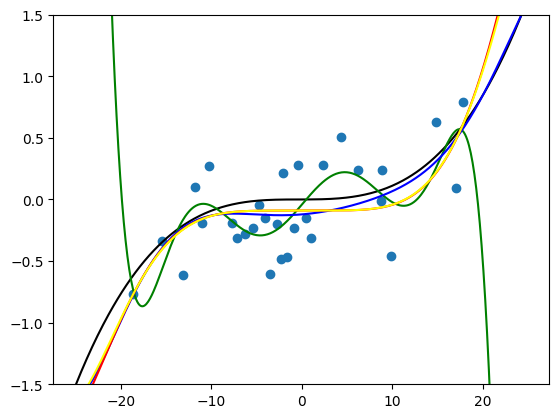

In [37]:
# 多項式回帰の回帰式（7次関数）
# 元の関数を描画
plt.plot(x_plot, y_plot, color='black')
# サンプルを散布
plt.scatter(x_train, y_train)

# ★7次関数で近似て過学習になった推論を描画
plt.plot(x_plot, y_test_predict_septic, color='green')
plt.plot(x_plot, y_test_predict_ridge, color='blue')
plt.plot(x_plot, y_test_predict_lasso, color='red')
plt.plot(x_plot, y_test_predict_en, color='yellow')

# 縦の表示範囲を指定
plt.ylim([-1.5, 1.5])

# グラフを表示
plt.show()

##### 自由度調整済み決定係数（R2乗値）

###### LinearRegression

In [38]:
print('<septic train>')
print('R^2: %.3f' % model_septic.score(x_train_septic, y_train))
print('adjusted R^2: %.3f' % adjusted(model_septic.score(x_train_septic, y_train), len(y_train), 7))
print('<septic test>')
print('R^2: %.3f' % model_septic.score(x_test_septic, y_test))
print('adjusted R^2: %.3f' % adjusted(model_septic.score(x_test_septic, y_test), len(y_train), 7))

<septic train>
R^2: 0.522
adjusted R^2: 0.370
<septic test>
R^2: -67.650
adjusted R^2: -89.494


###### Ridge

In [39]:
print('<ridge train>')
print('R^2: %.3f' % model_ridge.score(x_train_septic, y_train))
print('adjusted R^2: %.3f' % adjusted(model_ridge.score(x_train_septic, y_train), len(y_train), 7))
print('<ridge test>')
print('R^2: %.3f' % model_ridge.score(x_test_septic, y_test))
print('adjusted R^2: %.3f' % adjusted(model_ridge.score(x_test_septic, y_test), len(y_train), 7))

<ridge train>
R^2: 0.406
adjusted R^2: 0.217
<ridge test>
R^2: 0.966
adjusted R^2: 0.955


###### Lasso

In [40]:
print('<lasso train>')
print('R^2: %.3f' % model_lasso.score(x_train_septic, y_train))
print('adjusted R^2: %.3f' % adjusted(model_lasso.score(x_train_septic, y_train), len(y_train), 7))
print('<lasso test>')
print('R^2: %.3f' % model_lasso.score(x_test_septic, y_test))
print('adjusted R^2: %.3f' % adjusted(model_lasso.score(x_test_septic, y_test), len(y_train), 7))

<lasso train>
R^2: 0.374
adjusted R^2: 0.175
<lasso test>
R^2: 0.850
adjusted R^2: 0.802


###### ElasticNet

In [41]:
print('<en train>')
print('R^2: %.3f' % model_en.score(x_train_septic, y_train))
print('adjusted R^2: %.3f' % adjusted(model_en.score(x_train_septic, y_train), len(y_train), 7))
print('<en test>')
print('R^2: %.3f' % model_en.score(x_test_septic, y_test))
print('adjusted R^2: %.3f' % adjusted(model_en.score(x_test_septic, y_test), len(y_train), 7))

<en train>
R^2: 0.374
adjusted R^2: 0.175
<en test>
R^2: 0.883
adjusted R^2: 0.846


##### 確認（次元削減、ノルムの縮小

###### LinearRegression

In [42]:
# 重み
print("model_septic.coef_:", model_septic.coef_)
# L2ノルム
print("LA.norm(model_septic.coef_):", LA.norm(model_septic.coef_))
# L1ノルム
print("LA.norm(model_septic.coef_, ord=1):", LA.norm(model_septic.coef_, ord=1))

model_septic.coef_: [ 0.00000000e+00  8.65504975e-02  4.11571243e-04 -1.64948411e-03
 -4.05575050e-06  9.48940782e-06  5.18992806e-09 -1.49851211e-08]
LA.norm(model_septic.coef_): 0.08656719307305251
LA.norm(model_septic.coef_, ord=1): 0.0886251182088282


###### Ridge

In [43]:
# 重み
print("model_ridge.coef_:", model_ridge.coef_) # 次元削減の確認
# L2ノルム
print("LA.norm(model_ridge.coef_):", LA.norm(model_ridge.coef_)) # 縮小の確認
# L1ノルム
print("LA.norm(model_ridge.coef_, ord=1):", LA.norm(model_ridge.coef_, ord=1)) # 縮小の確認

model_ridge.coef_: [ 0.00000000e+00  6.00178293e-03  1.35634933e-03  1.14754021e-06
 -5.17185214e-06  4.16096324e-07  5.24302212e-09 -4.29044302e-10]
LA.norm(model_ridge.coef_): 0.00615313822768824
LA.norm(model_ridge.coef_, ord=1): 0.007364873417818134


###### Lasso

In [44]:
# 重み
print("model_lasso.coef_:", model_lasso.coef_) # 次元削減の確認
# L2ノルム
print("LA.norm(model_lasso.coef_):", LA.norm(model_lasso.coef_)) # 縮小の確認
# L1ノルム
print("LA.norm(model_lasso.coef_, ord=1):", LA.norm(model_lasso.coef_, ord=1)) # 縮小の確認

model_lasso.coef_: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.84889999e-07  2.03058492e-09 -4.20064051e-10]
LA.norm(model_lasso.coef_): 4.848944326501055e-07
LA.norm(model_lasso.coef_, ord=1): 4.873406479230845e-07


###### ElasticNet

In [45]:
# 重み
print("model_en.coef_:", model_en.coef_) # 次元削減の確認
# L2ノルム
print("LA.norm(model_en.coef_):", LA.norm(model_en.coef_)) # 縮小の確認
# L1ノルム
print("LA.norm(model_en.coef_, ord=1):", LA.norm(model_en.coef_, ord=1)) # 縮小の確認

model_en.coef_: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.00299266e-07  1.98532010e-09 -4.68508620e-10]
LA.norm(model_en.coef_): 5.003034244200346e-07
LA.norm(model_en.coef_, ord=1): 5.027530946486256e-07
